In [43]:
import tensorflow as tf

In [44]:
import os
import cv2

## Convert Json label to image mask

In [72]:
import json
from skimage.draw import polygon
from skimage import io
import os
import glob
from tqdm import tqdm
import numpy as np

def fill_mask(blobs,mask,label):
    for l in blobs:
        fill_row_coords, fill_col_coords = polygon(l[1], l[0],l[2])
        mask[fill_row_coords, fill_col_coords] = label


def convert_annotation_json_to_mask(path_to_annotation_json, path_to_masks_folder,classes,label_value,pixel_value):

    f = open(path_to_annotation_json)
    train = []
    objects = json.load(f)
    annotations = objects['shapes']
    h = objects['imageHeight']
    w = objects['imageWidth']
    mask = np.zeros((h, w)).astype('uint8')
    for annot in annotations:
        label= annot['label']
        points = annot['points']

        x_coord = []
        y_coord = []
        l = []
        for p in points:
            x_coord.append(int(p[0]))
            y_coord.append(int(p[1]))
        shape = (h, w)
        l.append(np.array(x_coord))
        l.append(np.array(y_coord))
        l.append(shape)
        
        if not label_value.get(label):
            label_value[label]=pixel_value[0]
            pixel_value[0]+=100

        if not classes.get(label):
            classes[label]=[l]
        else:
            classes[label].append(l)
            
    for label in classes:
        fill_mask(classes[label], mask,label_value[label])
        classes[label]=[]
        
    io.imsave(path_to_masks_folder, mask)

def get_classes(dataset_path):
    classes=dict()
    count=0
    pixel_value=[100]
    label_value=dict()
    for dirpath, dirname, filename in os.walk(dataset_path):
        path_to_annotation_json=glob.glob(dirpath+"/*.json")
        for json_file in path_to_annotation_json:
            path_to_mask_png=json_file[0:-5]+"_mask.png"
            convert_annotation_json_to_mask(json_file, path_to_mask_png,classes,label_value,pixel_value)
            count+=1

    assert count, "Dataset folder path does not contain any json mask file" 


    print(".png file of All json mask files saved in respective folders! ")
    labels=[1]*len(label_value)

    for label, value in label_value.items():
        labels[(value-100)//100]=label

    class_list=''
    for clss in labels:
        class_list += clss+"$"
    return class_list[0:-1]

In [1]:
classes = get_classes(r'G:\Intern project\DATA SET\Labelled Dataset\Dataset testing multi class')
print('classes names: ',classes.split('$'))

.png file of All json mask files saved in respective folders! 
classes names:  ['Deciduous', 'Coniferous']


## Data preprocessing

In [58]:
import os
import glob
from tqdm import tqdm
import cv2
import numpy as np
import keras
import tensorflow

class Dataset(keras.utils.Sequence):  
    def __init__(
            self, 
            dataset_path,
            n_classes,
            augmentation=None, 
    ):
        
        self.images_fps = []
        self.mask_fps=[]
        self.n_classes=n_classes

        for dirpath, dirnames, filenames in os.walk(dataset_path):
            mask_src=glob.glob(dirpath + '/*.png' )
            mask_src.sort()
            img_src = glob.glob(dirpath + '/*.jpg' )
            img_src += glob.glob(dirpath + '/*.jpeg' )
            img_src.sort()
            
            if len(img_src):
                assert len(mask_src)!=0,dirpath+ ", does not contain any annotation mask file of image/images "
                if len(mask_src)!=1:
                    assert len(mask_src)==len(img_src),dirpath+ ", does not contains total number of annotation mask files({ml}) equal to total number of images({il}) ".format(ml = len(mask_src), il = len(img_src))
                    self.mask_fps+=mask_src 
                    
                if len(mask_src)==1:
                    self.mask_fps+=[mask_src[0]]*len(img_src)
                self.images_fps+=img_src
                
            else:
                assert len(mask_src)==0,dirpath+ ", does not contain image files of annotation mask file/files "

        assert (len(self.images_fps)!=0), dataset_path+", does not contain images"
                
        self.actaul_size=len(self.mask_fps)
        self.augmentation = augmentation  
    
    def __getitem__(self, i):
        
        j=i
        if i>=self.actaul_size:
            j=i-self.actaul_size
        image = cv2.imread(self.images_fps[j])  
        h,w,_=image.shape
        h=256
        w=256    
        image = cv2.resize(image, (w, h))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask1 = cv2.imread(self.mask_fps[j],0)   

        mask=[(mask1==((i+1)*100)) for i in range(self.n_classes)] 

        mask = np.stack(mask, axis=-1).astype('float')
        
        # add background to mask
        if mask.shape[-1] != 1:
                background = 1 - mask.sum(axis=-1, keepdims=True)
                mask = np.concatenate((mask, background), axis=-1)
                
        mask=cv2.resize(mask, (w, h))
        mask=1.0*(mask>0.9)
        
        # apply augmentations
        if i>=self.actaul_size:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
        
    def __len__(self):
        if self.augmentation:
            return self.actaul_size*2
        return self.actaul_size
       



Load data from dataset and form batches

In [59]:
import keras
class Dataloder(keras.utils.Sequence):

    def __init__(self,indexes, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = indexes
        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[self.indexes[j]])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  
        

## Data Augmentation

In [61]:
# !pip uninstall imgaug
# !pip install imgaug==0.4.0
# !pip install albumentations

In [47]:
## Data Augmentation
import albumentations as A

def aug():
    train_transform = [

        A.IAAAdditiveGaussianNoise(p=0.1),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=5, shift_limit=0.1, p=0.9, border_mode=0),
        A.HorizontalFlip(p=0.5),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

Function for visualising multiple images together

In [1]:
import matplotlib.pyplot as plt
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

#### Importing Dataset

In [188]:
dataset_path = r'G:\Intern project\DATA SET\Labelled Dataset\Dataset testing multi class'
dataset = Dataset(dataset_path,2,augmentation=aug())

### Visualization of Data

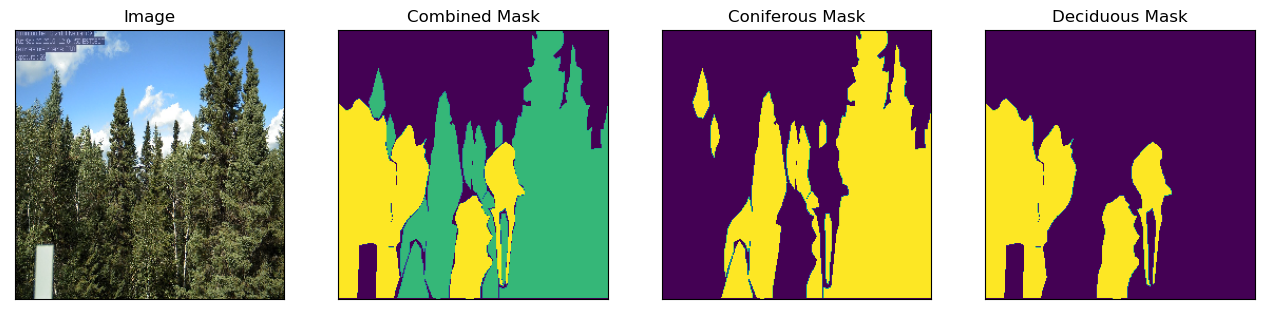

In [190]:
image, mask = dataset[0]
visualize(
    image=image, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### With Augmentation:

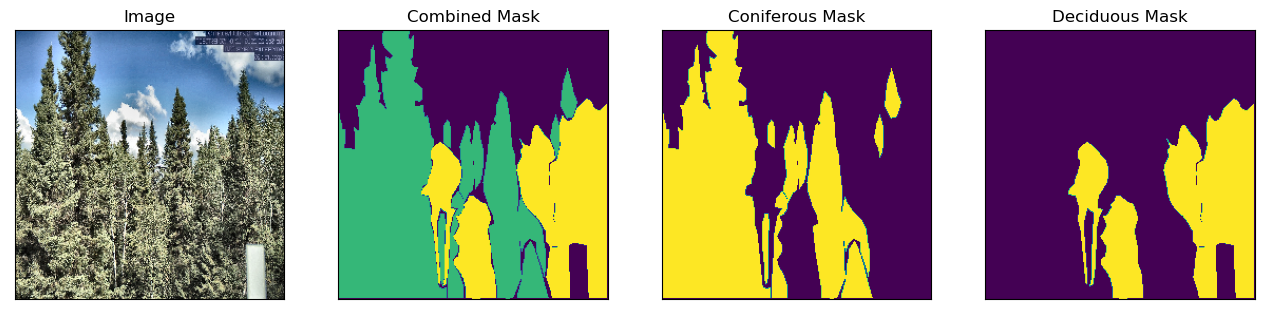

In [191]:
image, mask = dataset[(len(dataset)//2)]
visualize(
    image=image, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### Training and Validation Dataset
Training Data: 85%

Validation/Testing Data: 15%

In [130]:
from sklearn.model_selection import train_test_split

dataset_indexes=list(range(0,len(dataset)))
train_dataset, test_dataset = train_test_split(dataset_indexes, test_size = 0.15, random_state = 42)

#### Importing segmentation_models library for Model creation

In [132]:
# !pip3 install -U segmentation-models

In [ ]:
import segmentation_models as sm

#### Defining loss and performance metrics

In [ ]:
dice_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [ ]:
BACKBONE = 'efficientnetb3'
LR = 0.001
n_classes = 2+1
activation = 'softmax'
sm.set_framework('tf.keras')
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
opt = keras.optimizers.Adam(LR)
model.compile(opt, total_loss, metrics)

In [150]:
train_dataloader = Dataloder(train_dataset,dataset, batch_size=16)
test_dataloader = Dataloder(test_dataset,dataset, batch_size=1)

In [151]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   1080        ['input_3[0][0]']                
                                40)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   160         ['stem_conv[0][0]']              
                                40)                                                         

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, None, None,   1296       ['block2a_expand_activation[0][0]
 D)                             144)                             ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, None, None,   576        ['block2a_dwconv[0][0]']         
 )                              144)                                                              
                                                                                                  
 block2a_activation (Activation  (None, None, None,   0          ['block2a_bn[0][0]']             
 )                              144)                                                              
                                                                                                  
 block2a_s

 )                              192)                                                              
                                                                                                  
 block2c_activation (Activation  (None, None, None,   0          ['block2c_bn[0][0]']             
 )                              192)                                                              
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_s

 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, None, None,   0           ['block3b_activation[0][0]',     
          

                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_s

                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, None, None,   0           ['block4c_activation[0][0]',     
                                576)                              'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, None, None,   55296       ['block4c_se_excite[0][0]']      
                                96)                                                               
          

 block4e_se_reshape (Reshape)   (None, 1, 1, 576)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 24)     13848       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, None, None,   0           ['block4e_activation[0][0]',     
                                576)                              'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, None, None,   55296       ['block4e_se_excite[0][0]']      
          

                                                                                                  
 block5b_se_excite (Multiply)   (None, None, None,   0           ['block5b_activation[0][0]',     
                                816)                              'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, None, None,   110976      ['block5b_se_excite[0][0]']      
                                136)                                                              
                                                                                                  
 block5b_project_bn (BatchNorma  (None, None, None,   544        ['block5b_project_conv[0][0]']   
 lization)                      136)                                                              
                                                                                                  
 block5b_d

 block5d_se_expand (Conv2D)     (None, 1, 1, 816)    28560       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, None, None,   0           ['block5d_activation[0][0]',     
                                816)                              'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, None, None,   110976      ['block5d_se_excite[0][0]']      
                                136)                                                              
                                                                                                  
 block5d_project_bn (BatchNorma  (None, None, None,   544        ['block5d_project_conv[0][0]']   
 lization)                      136)                                                              
          

                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 816)    28560       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, None, None,   0           ['block6a_activation[0][0]',     
                                816)                              'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, None, None,   189312      ['block6a_se_excite[0][0]']      
                                232)                                                              
                                                                                                  
 block6a_project_bn (BatchNorma  (None, None, None,   928        ['block6a_project_conv[0][0]']   
 lization)

                                                                                                  
 block6c_project_conv (Conv2D)  (None, None, None,   322944      ['block6c_se_excite[0][0]']      
                                232)                                                              
                                                                                                  
 block6c_project_bn (BatchNorma  (None, None, None,   928        ['block6c_project_conv[0][0]']   
 lization)                      232)                                                              
                                                                                                  
 block6c_drop (FixedDropout)    (None, None, None,   0           ['block6c_project_bn[0][0]']     
                                232)                                                              
                                                                                                  
 block6c_a

                                1392)                             'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, None, None,   322944      ['block6e_se_excite[0][0]']      
                                232)                                                              
                                                                                                  
 block6e_project_bn (BatchNorma  (None, None, None,   928        ['block6e_project_conv[0][0]']   
 lization)                      232)                                                              
                                                                                                  
 block6e_drop (FixedDropout)    (None, None, None,   0           ['block6e_project_bn[0][0]']     
                                232)                                                              
          

 block7a_se_excite (Multiply)   (None, None, None,   0           ['block7a_activation[0][0]',     
                                1392)                             'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, None, None,   534528      ['block7a_se_excite[0][0]']      
                                384)                                                              
                                                                                                  
 block7a_project_bn (BatchNorma  (None, None, None,   1536       ['block7a_project_conv[0][0]']   
 lization)                      384)                                                              
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, None, None,   884736      ['block7a_project_bn[0][0]']     
          

 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          544)                             ',                               
                                                                  'block4a_expand_activation[0][0]
                                                                 ']                               
          

                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, None, None,   4608        ['decoder_stage4_upsampling[0][0]
                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_s

### Model Training

In [200]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    callbacks = [keras.callbacks.ReduceLROnPlateau(), tf.keras.callbacks.EarlyStopping('val_loss', patience=5)],
    validation_data=test_dataloader, 
    validation_steps=len(test_dataloader),     
)

Epoch 1/40
45/45 [==============================] - 42s 928ms/step - loss: 1.2373 - iou_score: 0.2254 - f1-score: 0.3038 - val_loss: 1.2351 - val_iou_score: 0.2599 - val_f1-score: 0.3271
Epoch 2/40
45/45 [==============================] - 20s 445ms/step - loss: 0.9516 - iou_score: 0.3815 - f1-score: 0.4462 - val_loss: 0.9057 - val_iou_score: 0.4516 - val_f1-score: 0.4965
Epoch 3/40
45/45 [==============================] - 20s 447ms/step - loss: 0.8449 - iou_score: 0.4226 - f1-score: 0.4826 - val_loss: 0.8483 - val_iou_score: 0.5100 - val_f1-score: 0.5514
Epoch 4/40
45/45 [==============================] - 20s 448ms/step - loss: 0.7875 - iou_score: 0.5296 - f1-score: 0.4889 - val_loss: 0.8119 - val_iou_score: 0.5111 - val_f1-score: 0.5488
Epoch 5/40
45/45 [==============================] - 20s 448ms/step - loss: 0.7491 - iou_score: 0.6253 - f1-score: 0.4863 - val_loss: 0.7943 - val_iou_score: 0.5881 - val_f1-score: 0.5577
Epoch 6/40
45/45 [==============================] - 20s 451ms/ste

In [ ]:
model.save('my_model.h5')

### Evaluation

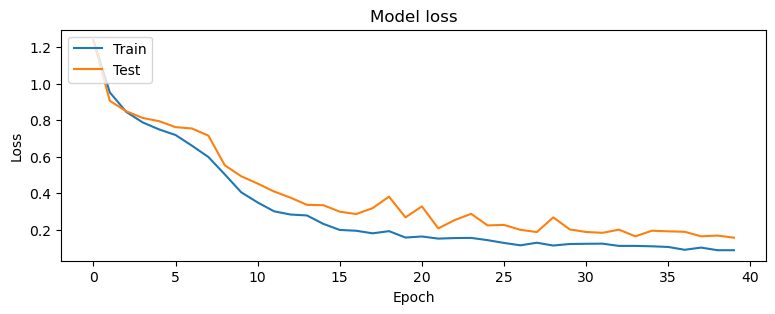

In [132]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

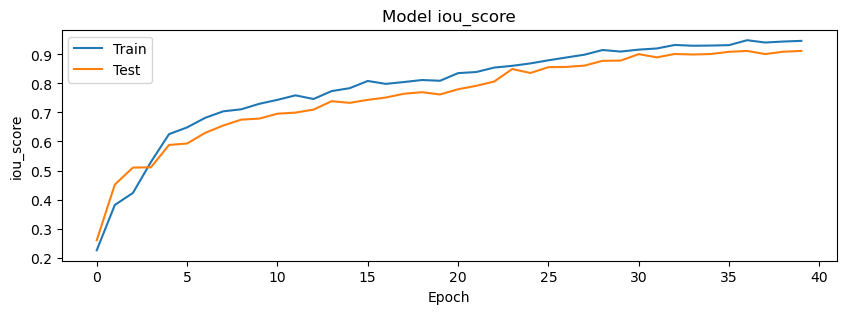

In [190]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [201]:
scores = model.evaluate(test_dataloader)

76/76 [==============================] - 33s 432ms/step - loss: 0.1567 - iou_score: 0.9121 - f1-score: 0.9234


In [203]:
print("Loss: ",scores[0])
print("iou :",scores[1])
print("f1-score :",scores[2])

Loss:  0.1567145701646805
iou : 0.9121432443618774
f1-score : 0.923451619338989


In [198]:
test_pred =model.predict(test_dataloader)

76/76 [==============================] - 23s 304ms/step


### True Mask

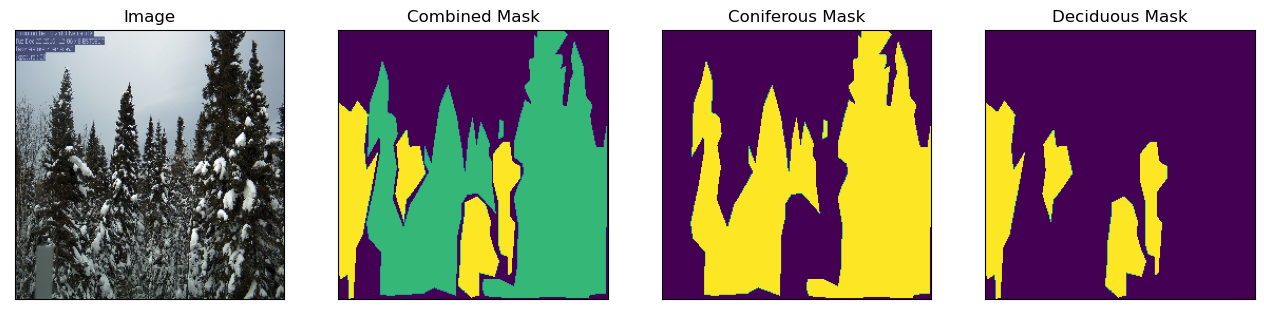

In [204]:
image,mask = test_dataloader[20]

img=image[0]
visualize(
    image=img, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)

### Predicted Mask

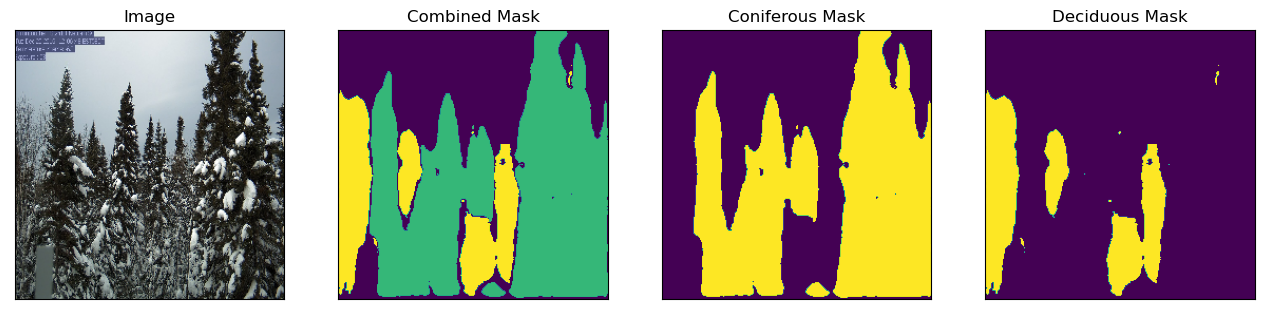

In [219]:
mask = test_pre[20]>0.5

visualize(
    image=img, 
    combined_mask = (mask[..., 1].squeeze())*0.4+(mask[..., 0].squeeze())*0.6,
    coniferous_mask = mask[..., 1].squeeze(),
    deciduous_mask = mask[..., 0].squeeze()
)